# Modeling nucleic acid recovery from airplane filters
Lennart Justen
2023-01-25

Parameter estimates are in [this Gsheet](https://docs.google.com/spreadsheets/d/11WNgxjYTXM_cgXXY7NhlwtKz-FrHl5ZhDisSDDExdMo/edit?usp=sharing)

## Plane parameters
Consider a plane of volume $V$ and with number of passengers $N$, were some fraction of them $\zeta$ are infected with a pathogen. Of the fraction infected with the pathogen, a fraction $\alpha$ are actively shedding the pathogen into the air. All passengers are in the plane for a total time $T$.

In [45]:
import numpy as np
import matplotlib.pyplot as plt

N = 200  # number of passengers (person)
zeta = 0.05  # fraction of passengers infected
alpha = 0.8  # fraction of infected passengers shedding

V = 231000 # volume of plane (L)

T = 8*60*60  # time on airplane (s)

## Nucleic acid generation
Two kinds of nucleic acid (NA) are generated by passengers: target (pathogen) NA and off-target NA. Every passenger, whatever their infection status, is assumed to shed off target NA while only passengers who are infected also shed target (pathogen) NA. Given per-person NA shedding rates, we can calculate the rate of change of NA concentration in the airplane in the absence of any air exchange.

$\frac{dc_{sp}(t)}{dt}  = \gamma_p\frac{\zeta\alpha N}{V}$ = *constant*, where

$\gamma_p$ = the rate of target pathogen NA shedding per person per second (ng person-1 s-1), and
$\frac{dc_{sp}}{dt}$  = the rate of change of target pathogen NA concentration (ng L-1 s-1) in the plane due to shedding.

The same holds for off-target NA, denoted by the $_o$ subscript.

$\frac{dc_{so}}{dt} = \gamma_o\frac{N}{V}$, where

$\gamma_o$ = the rate of off-target NA shedding per person per second (ng person-1 s-1), and
$\frac{dc_{so}}{dt}$  = the rate of change of off-target NA concentration (ng L-1 s-1) in the plane due to shedding.


In [46]:
gamma_p = 1.5*10**-6  # rate of target pathogen NA shedding per person per second (ng person-1 s-1)
# gamma_o = 0.1  # rate of off-target NA shedding per person per second (ng person-1 s-1)

## Nucleic acid removal
On- and off-target NA are removed from the airplane via a ventilation system coupled with a filter operating at some fixed air exchange per hour (ACH), or more helpfully, air changes per second (ACS).

$ACS = \frac{ACH}{60\cdot60} = \frac{f}{V}$, where

$f$ = flow rate (L/s), and
$V$  = volume of the plane (L)

Future versions of this model could include some decay constant representing NA settling to the ground or otherwise degrading in the air. This phenomenon would likewise contribute to the removal of NA but via a different mechanism.

In [47]:
fr = 700  # flow rate (L/s)



**Assumption 1:** assume that the return air is entirely "clean" i.e. has no nucleic acid content (I'll revist this later).

The change in NA concentration in the air due to its removal by the filter depends on the concentration of NA already in the air.

$\frac{dc_{rp}(t)}{dt}=ACS\cdot c_p(t)$, where

$\frac{dc_{rp}}{dt}$ = the rate of change in target pathogen NA concentration in the airplane due to removal by filter, and
$c_p$ = the concentration of the pathogen in the air.

As before, the same logic applied to off-target NA.


$\frac{dc_{ro}(t)}{dt}=ACS\cdot c_o(t)$, where

$\frac{dc_{ro}}{dt}$ = the rate of change in off-target NA concentration in the airplane due to removal by filter, and
$c_o$ = the concentration of off-target NA in the air.

## Concentration of NA in the air
We've now come up with expression for NA generation and removal, expressed in terms of the changes in concentration. From this, we can describe the overall rate of change of NA concentration as:

$\frac{c_p(t)}{dt} = \frac{c_{sp}}{dt}-\frac{c_{rp}}{dt} = \frac{\zeta\alpha N\gamma_p}{V} - ACS\cdot c_p(t)$


This turns out to be an ordinary differential equation of the form

$\frac{dy}{dt}=a-by$ where $a$ is a constant forcing function.

Solving the differential equation for $c_p(t)$ with the initial condition $c_p(0)=0$ we get

$c_p(t)=\frac{\zeta\alpha N\gamma_p}{V\cdot ACS}(1-e^{-ACS\cdot t})$

Once again, the same logic applied for $c_o$

$c_o(t) = \frac{N\gamma_s}{V\cdot ACS}(1-e^{-ACS\cdot t})$

In [48]:
def c_p(zeta, alpha, N, V, fr, gamma_p, t):
    # concentration of target pathogen NA as a function of time (ng L-1)
    return (zeta*alpha*N*gamma_p/fr)*(1-np.exp(-fr*t/V))

def c_o(N, V, fr, gamma_o, t):
    # concentration of off-target NA as a function of time (ng L-1)
    return (N*gamma_o/fr)*(1-np.exp(-fr*t/V))

## Collection of NA in filter
**Assumption 2: All air is driven through a filter in the airplane**
* Also, recall that Assumption 1 says that all return air in the airplane has no NA content. For a more detailed model, one could say that some amount of NA passes through the filter and is returned into the airplane.
* Another possible expansion is NA recovery efficiency i.e., the fraction of NA you actually end up sequencing compared to what was caught on the filter.

Consider that the filter through which air is moving has an efficiency $\eta$ for removing NA, and that your process for extracting NA from the filter has an efficiency $\beta$. Then we can express the amount of NA collected in the filter per unit time as

$\frac{m_p}{dt} = f\eta\beta c_p$, where

$\frac{m_p}{dt}$ = the rate of collection of target pathogen NA (ng s-1), and as before
$f$ = flow rate (L s-1)

Plugging in our expression for $c_p$ and doing some rearranging, we get

$\frac{dm_p}{dt}=\eta\beta\zeta\alpha N\gamma_p(1-e^{-ft/V})$

and likewise

$\frac{dm_o}{dt}=\eta\beta N\gamma_o(1-e^{-ft/V})$

To calculate the total amount of NA collected over some time $T$ (in this case the duration of the flight), one need only integrate:

$m_p = \int_{0}^{T}\eta\beta\zeta\alpha N\gamma_p(1-e^{-ft/V})dt = \eta\beta\zeta\alpha N\gamma_p(\frac{e^{-fT/V}}{f/V}+T)$

In [49]:
eta = 99.5  # Filter efficiency
beta = 0.80   # NA sample recovery efficiency

def m_p(fr, eta, beta, t):
    return fr*eta*beta*c_p(zeta, alpha, N, V, fr, gamma_p, t)*t

# def m_p(fr, eta, beta, t):
#    return eta*zeta*beta*alpha*N*gamma_p*(np.exp(-fr*t/V)/(fr/V)+t)

## Relative abundance
The relative abundance is simply $m_p/m_o = \frac{\zeta\alpha\gamma_p}{\gamma_o}$

## Visualizing the results

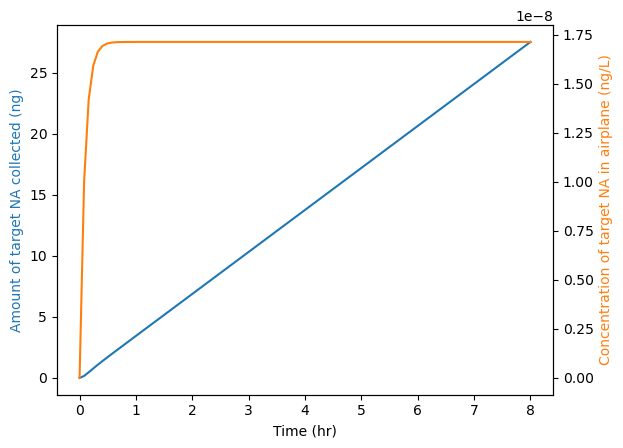

In [50]:
time = np.linspace(0,8,100)

mass_over_time = [m_p(fr, eta, beta, t*60*60) for t in time]
concentration_over_time = [c_p(zeta, alpha, N, V, fr, gamma_p, t*60*60) for t in time]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(time, mass_over_time, 'C0')
ax2.plot(time, concentration_over_time, 'C1')

ax1.set_xlabel('Time (hr)')
ax1.set_ylabel('Amount of target NA collected (ng)', color='C0')
ax2.set_ylabel('Concentration of target NA in airplane (ng/L)', color='C1')

plt.show()

The results of the model shown above generally agree with a previous study that measured the concentration of Influenza A (IAV) in airplane cabins using qPCR. [Yang et al. (2011)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3119883/) collected air samples with a multi-stage solid impactor from three cross-country flights between Roanoke, VA and San Francisco, CA. One of the flight contained no detectable IAV while the other two contained an equivalent of 14±1.0 and 11±1.1 IAV copies per liter respectively. The copies per liter concentrations roughly correspond to between 1.60E-7 and 2.04E-7 ng per L, which agrees quite well with the model.


## Next steps
* Parameterize NA shedding rates
* Investigate NA recovery efficiency from HEPA filters.
* Add a process to the model by which NA that is not intercepted in the filter returns into the airplane cabin.